In [1]:
! pip install --quiet "lightning"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 8.8 MB/s eta 0:00:00


In [2]:
!wget https://figshare.com/ndownloader/files/29138334?private_link=0c1dfc3be66eb622cf85

--2024-11-30 15:02:30--  https://figshare.com/ndownloader/files/29138334?private_link=0c1dfc3be66eb622cf85
Resolving figshare.com (figshare.com)... 54.228.51.51, 34.252.194.191, 2a05:d018:1f4:d000:2ff1:256e:d815:335, ...
Connecting to figshare.com (figshare.com)|54.228.51.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 297225812 (283M) [application/zip]
Saving to: ‘29138334?private_link=0c1dfc3be66eb622cf85’

29138334?private_li 100%[===================>] 283.46M  13.6MB/s    in 35s     

2024-11-30 15:03:06 (8.00 MB/s) - ‘29138334?private_link=0c1dfc3be66eb622cf85’ saved [297225812/297225812]



In [3]:
!mv 29138334?private_link=0c1dfc3be66eb622cf85 cifar.zip
!unzip cifar.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/train/Truck/aerial_ladder_truck_s_000001.png  
  inflating: images/train/Truck/aerial_ladder_truck_s_000006.png  
  inflating: images/train/Truck/aerial_ladder_truck_s_000015.png  
  inflating: images/train/Truck/aerial_ladder_truck_s_000030.png  
  inflating: images/train/Truck/aerial_ladder_truck_s_000042.png  
  inflating: images/train/Truck/aerial_ladder_truck_s_000063.png  
  inflating: images/train/Truck/aerial_ladder_truck_s_000068.png  
  inflating: images/train/Truck/aerial_ladder_truck_s_000074.png  
  inflating: images/train/Truck/aerial_ladder_truck_s_000075.png  
  inflating: images/train/Truck/aerial_ladder_truck_s_000076.png  
  inflating: images/train/Truck/aerial_ladder_truck_s_000079.png  
  inflating: images/train/Truck/aerial_ladder_truck_s_000080.png  
  inflating: images/train/Truck/aerial_ladder_truck_s_000083.png  
  inflating: images/train/Truck/aerial_ladder_truck_s_000087.png  
  inflating

In [4]:
from glob import glob  # For file path matching and retrieval
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations on arrays
import os  # For operating system interface
import lightning.pytorch as L  # For PyTorch Lightning functionality
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping  # Model callbacks
from lightning.pytorch.callbacks import ModelSummary  # For summarizing model architecture
import torchmetrics  # For PyTorch metrics computation
import torch  # For PyTorch deep learning framework
from torch import nn  # For building neural network modules
import torchvision  # For computer vision utilities and datasets
from torchvision import transforms  # For data transformations
import torchvision.transforms.functional as F  # Functional transformations
import matplotlib.pyplot as plt  # For plotting graphs
from sklearn.model_selection import train_test_split  # For data splitting
import random  # For random number generation
import torch
from torchvision import transforms
def set_seed(seed: int = 0) -> None:
    """Set random seed for reproducibility across numpy, random, torch, and CUDA."""
    np.random.seed(seed)  # Seed for numpy operations
    random.seed(seed)  # Seed for random module
    torch.manual_seed(seed)  # Seed for PyTorch on CPU
    torch.cuda.manual_seed(seed)  # Seed for PyTorch on CUDA GPU

    # Ensure reproducibility on CuDNN backend
    torch.backends.cudnn.deterministic = True  # Disable nondeterministic algorithms
    torch.backends.cudnn.benchmark = False  # Disable performance optimizations for determinism

    # Set a fixed value for the hash seed for reproducibility
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")  # Confirm seed setting

# Set default seed for reproducibility
set_seed()

Random seed set as 0


In [5]:
test_path = "/content/cifar10_raw/images/test/"  # Path to test dataset
train_path = "/content/cifar10_raw/images/train/"  # Path to training dataset

# List all file or directory names in the training path directory
list_ = [name for name in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, name))]
string2int = {name: index for index, name in enumerate(list_)}
def get_path(path):
    """Generate a list of dictionaries with image paths, labels, and class names for a given dataset path."""
    paths = []
    for name in list_:
        # Retrieve all .jpg files within each subdirectory under the given path
        l = glob(f"{path}{name}/*.png")

        # Append each image's path and its label (converted to int) to the paths list
        for i in l:
            paths.append({
                "name": name,
                "path": i,
                "label": string2int[name]
            })

    return paths

# Generate lists of paths with labels for both training and validation datasets
train_paths = get_path(train_path)
test_paths = get_path(test_path)
test_paths, _ = train_test_split(test_paths, train_size=0.4, random_state=0)
train_paths, _ = train_test_split(train_paths, train_size=0.4, random_state=0)
train_paths, val_paths = train_test_split(train_paths, test_size=0.2, random_state=0)

In [6]:
class DataSet(torch.utils.data.Dataset):
    """Custom Dataset for loading images and their corresponding labels."""

    def __init__(self, features, transform=None):
        """Initialize the dataset with features and optional transformations.

        Args:
            features (list): List of dictionaries containing image paths and labels.
            transform (callable, optional): Optional transform to be applied on the images.
        """
        super(DataSet, self).__init__()
        self.features = features  # Store the list of features (paths and labels)
        self.transform = transform  # Store the transformation if provided

    def __len__(self):
        """Return the total number of samples in the dataset."""
        return len(self.features)

    def __getitem__(self, idx):
        """Retrieve an item from the dataset given an index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            dict: A dictionary containing the image tensor and its corresponding label.
        """
        # Get the path of the image based on the index
        paths = self.features[idx]["path"]

        # Read the image from the path
        images = torchvision.io.read_image(paths)

        # Convert grayscale image to 3 channels by stacking
        #images = torch.stack([images[0], images[0], images[0]], 0)

        # ensure image has 3 channels:
        if images.shape[0] == 1:
          images = images.repeat(3,1,1)


        # Apply transformations if any
        if self.transform is not None:
            images = self.transform(images)

        # Retrieve the label for the current index
        label = torch.tensor(self.features[idx]["label"])
        return {"images": images, "labels": label}

# Instantiate the dataset
train_dataset = DataSet(train_paths)
test_dataset = DataSet(test_paths)
val_dataset = DataSet(val_paths)

In [7]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 16000
Number of validation samples: 4000
Number of test samples: 4000


In [8]:
# Define batch size and number of workers for DataLoader
batch_size = 32
num_workers = 2

# Define transformations for training images
train_transforms = transforms.Compose([
    transforms.ToPILImage(),  # Convert image to PIL format
    transforms.Resize((224, 224)),  # Resize image to 224x224
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),  # Adjust image color properties
    transforms.ToTensor(),  # Convert image to tensor format
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize using ImageNet mean and std
])

# Define transformations for test/validation images
test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Initialize datasets with corresponding transformations
train_dataset = DataSet(train_paths, transform=train_transforms)
test_dataset = DataSet(test_paths, transform=test_transforms)
val_dataset = DataSet(val_paths, transform=test_transforms)

# Create DataLoaders for each dataset
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers
)


[Vanilla Convolution Operation](https://medium.com/visionwizard/mixconv-mixed-depthwise-convolutional-kernels-from-google-brain-628cf5802264)

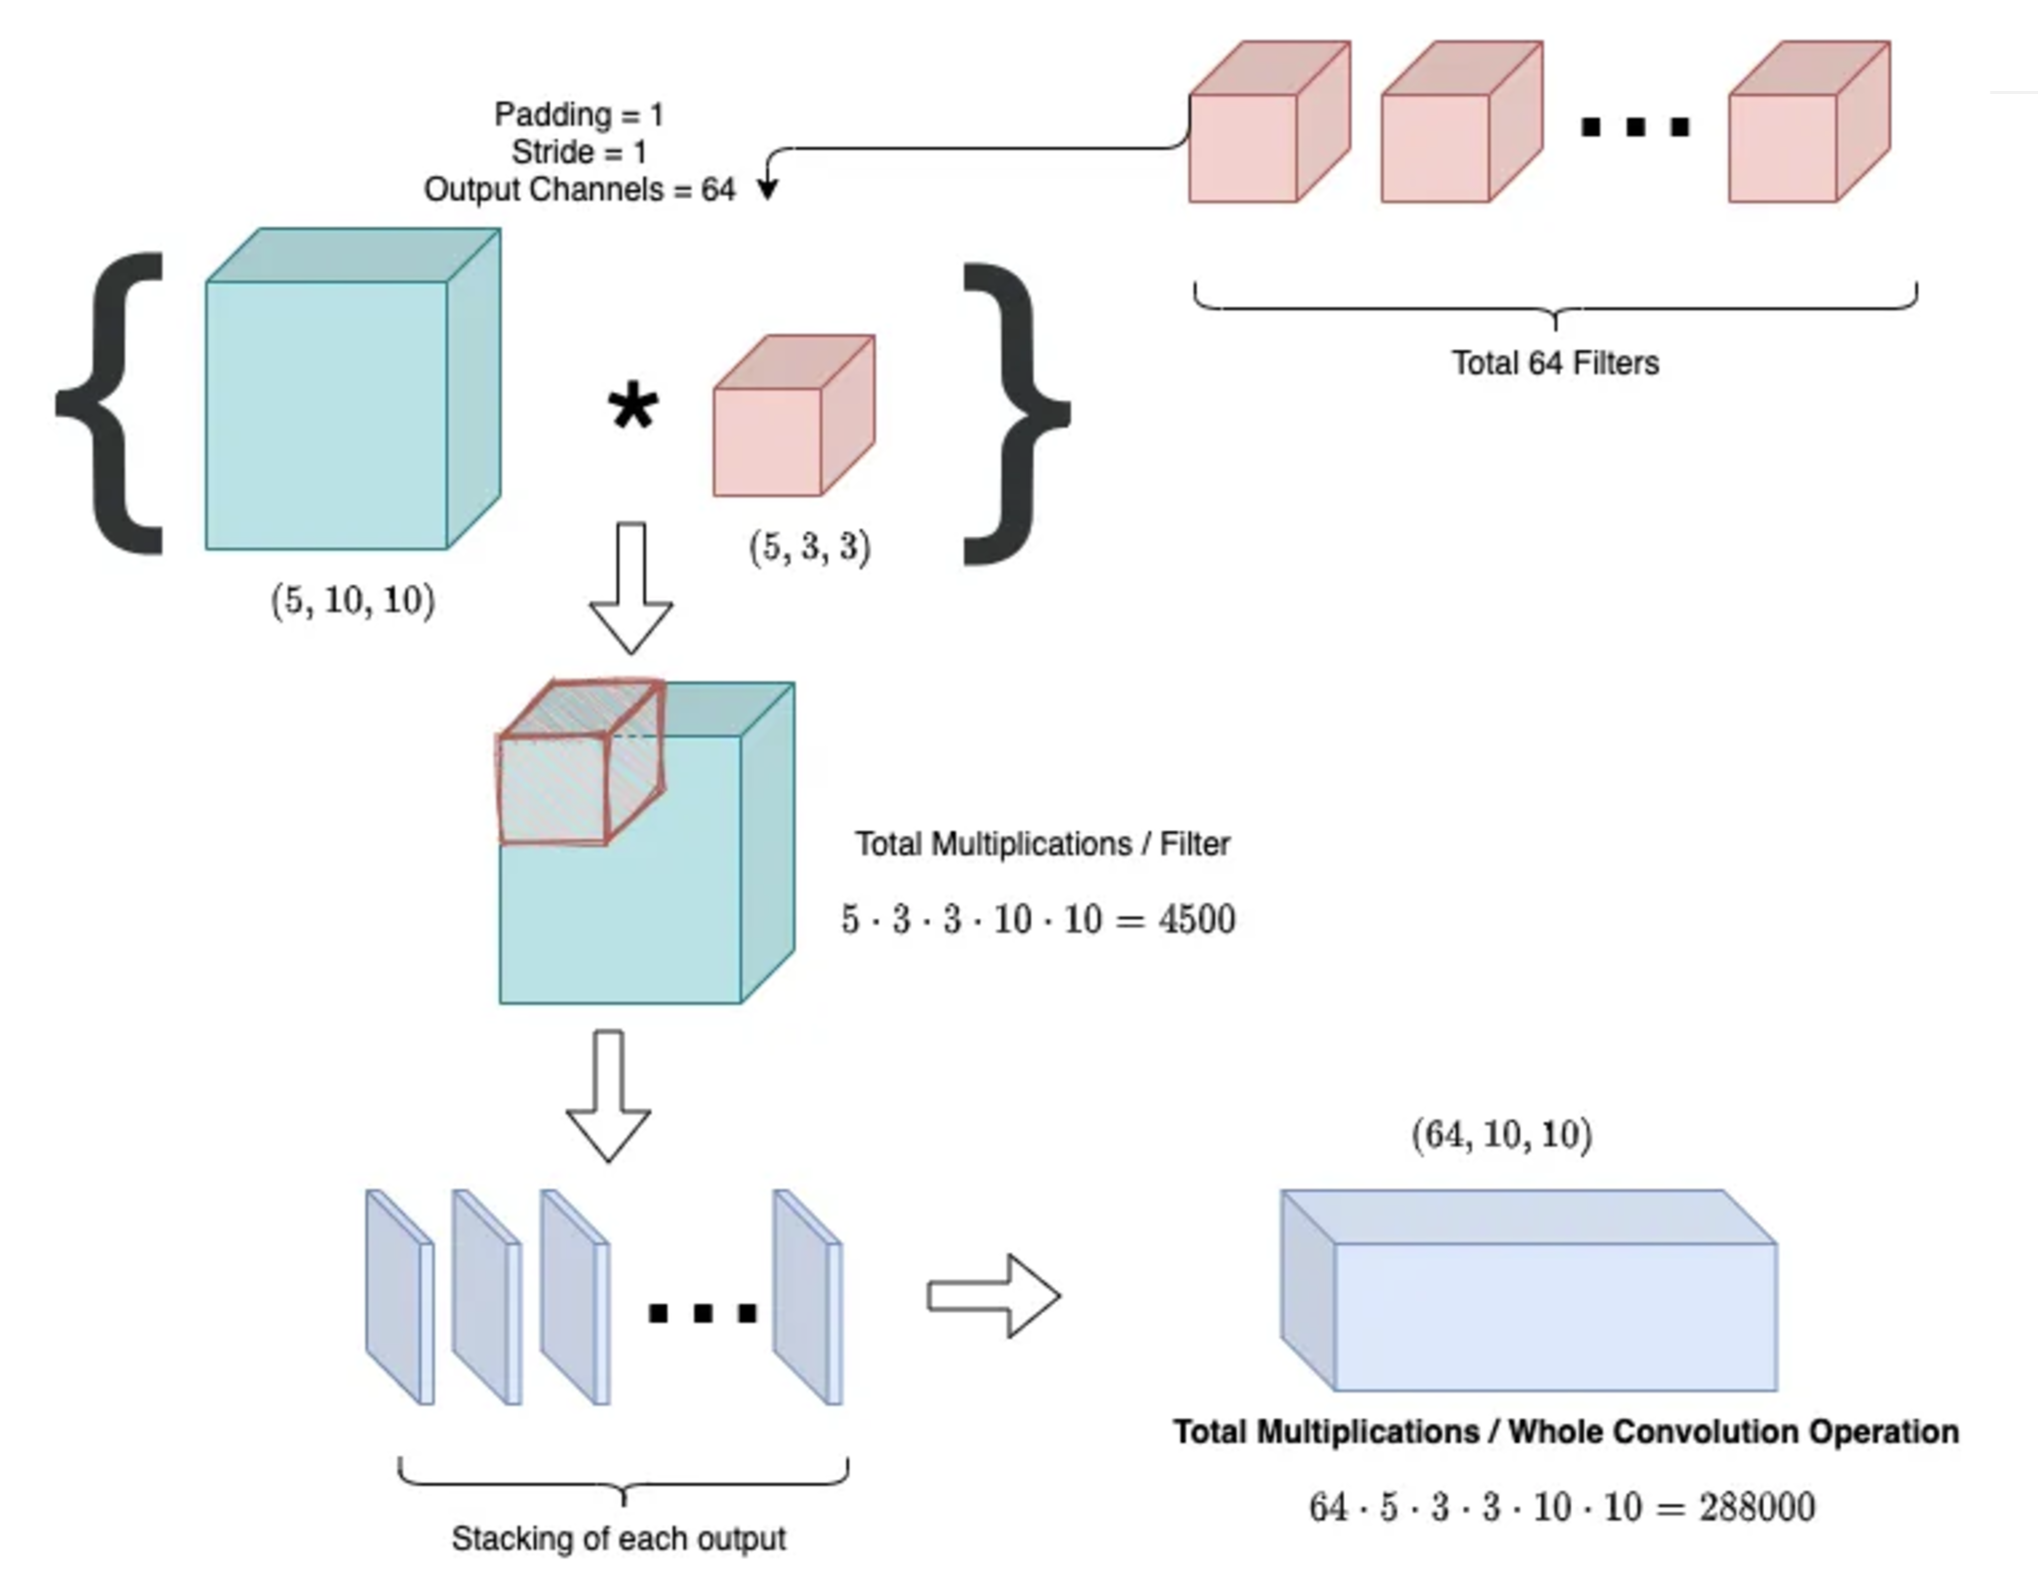

[Depthwise Separable Convolution Operations](https://medium.com/visionwizard/mixconv-mixed-depthwise-convolutional-kernels-from-google-brain-628cf5802264)

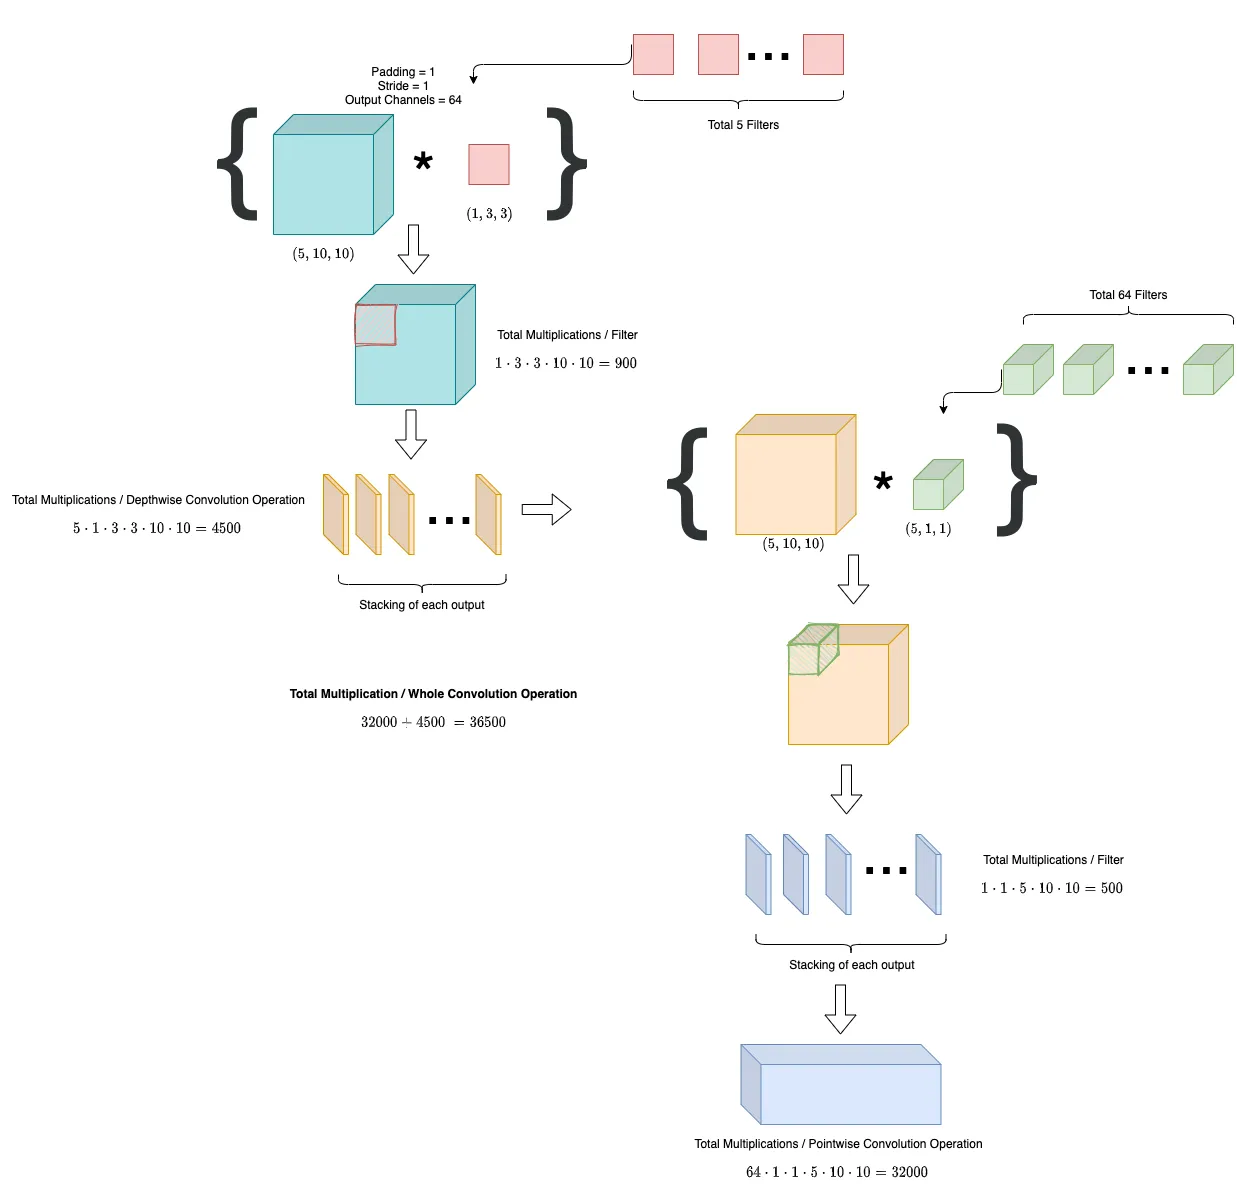

In [9]:
import torch
import torch.nn as nn

class DepthwiseSeparableConv(nn.Module):
    """
    Implements a Depthwise Separable Convolutional layer,
    which is more efficient compared to standard convolution layers.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        stride (int, optional): Stride of the convolution. Default is 1.
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # Depthwise convolution: Applies a single convolutional filter per input channel.
        self.depthwise = nn.Conv2d(
            in_channels, in_channels, kernel_size=3,
            stride=stride, padding=1, groups=in_channels, bias=False
        )

        # Pointwise convolution: Applies a 1x1 convolution to combine the outputs from the depthwise step.
        self.pointwise = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, bias=False
        )

        # Batch normalization for regularization and acceleration of convergence.
        self.bn = nn.BatchNorm2d(out_channels)

        # Activation function to introduce non-linearity.
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        """
        Forward pass through the DepthwiseSeparableConv layer.

        Args:
            x (torch.Tensor): Input tensor of shape (N, C_in, H, W),
                              where N is the batch size, C_in is the number of input channels,
                              and H, W are the height and width of the input.

        Returns:
            torch.Tensor: Output tensor of shape (N, C_out, H_out, W_out),
                          where C_out is the number of output channels.
        """
        # Apply depthwise convolution.
        x = self.depthwise(x)

        # Apply pointwise convolution.
        x = self.pointwise(x)

        # Apply batch normalization.
        x = self.bn(x)

        # Apply ReLU activation.
        x = self.relu(x)

        return x


In [31]:
import torch
import torch.nn as nn
import lightning.pytorch as L
import torchmetrics

class MobileNet(L.LightningModule):
    def __init__(self, num_classes=1000, learning_rate=1e-3):
        super(MobileNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),  # Conv / s2
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(32, 64, stride=1),  # Conv dw / s1
            DepthwiseSeparableConv(64, 128, stride=2),  # Conv dw / s2
            DepthwiseSeparableConv(128, 128, stride=1),  # Conv dw / s1
            DepthwiseSeparableConv(128, 256, stride=2),  # Conv dw / s2
            DepthwiseSeparableConv(256, 256, stride=1),  # Conv dw / s1
            DepthwiseSeparableConv(256, 512, stride=2),  # Conv dw / s2
            DepthwiseSeparableConv(512, 512, stride=1),  # Conv dw / s1
            DepthwiseSeparableConv(512, 512, stride=1),  # Conv dw / s1
            DepthwiseSeparableConv(512, 512, stride=1),  # Conv dw / s1
            DepthwiseSeparableConv(512, 512, stride=1),  # Conv dw / s1
            DepthwiseSeparableConv(512, 512, stride=1),  # Conv dw / s1
            DepthwiseSeparableConv(512, 1024, stride=2),  # Conv dw / s2
            DepthwiseSeparableConv(1024, 1024, stride=1),  # Conv dw / s1
        )

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Dropout(0.5),  # Dropout with probability 0.5
            nn.Linear(1024, num_classes)
        )
        self.softmax = nn.Softmax(dim=1)

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.learning_rate = learning_rate

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.softmax(x)
        return x

    def training_step(self, batch, batch_idx):
       x, y = batch["images"], batch["labels"]
       y_hat = self(x)
       loss = nn.CrossEntropyLoss()(y_hat, y)
       acc = self.accuracy(y_hat, y)
       self.log('train_loss', loss)
       self.log('train_acc', acc)
       return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch["images"], batch["labels"]
        y_hat = self(x)
        val_loss = nn.CrossEntropyLoss()(y_hat, y)
        val_acc = self.accuracy(y_hat, y)
        self.log('val_loss', val_loss)
        self.log('val_acc', val_acc)
        return val_loss


    def test_step(self, batch, batch_idx):
        x, y = batch["images"], batch["labels"]
        y_hat = self(x)
        test_loss = nn.CrossEntropyLoss()(y_hat, y)
        test_acc = self.accuracy(y_hat, y)
        self.log('test_loss', test_loss)
        self.log('test_acc', test_acc)
        return test_loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

In [32]:
model_checkpoint = ModelCheckpoint(
    dirpath="checkpoint/",
    monitor="val_acc",
    verbose=True,
    mode="max",
    save_top_k=1
)
early_stopping = EarlyStopping(
    monitor="val_acc",
    mode="max",
    min_delta=1e-4,
    patience=5
)
callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

# Training
model = MobileNet(num_classes=10)
trainer = L.Trainer(max_epochs=10,gradient_clip_val=1.0, detect_anomaly=True, callbacks=callbacks, accelerator="gpu", devices=1)
trainer.fit(model, train_dataloader, val_dataloader)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 500: 'val_acc' reached 0.32900 (best 0.32900), saving model to '/content/checkpoint/epoch=0-step=500.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 500: 'val_acc' reached 0.32900 (best 0.32900), saving model to '/content/checkpoint/epoch=0-step=500.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 1000: 'val_acc' reached 0.40475 (best 0.40475), saving model to '/content/checkpoint/epoch=1-step=1000.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 1000: 'val_acc' reached 0.40475 (best 0.40475), saving model to '/content/checkpoint/epoch=1-step=1000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 1500: 'val_acc' reached 0.49800 (best 0.49800), saving model to '/content/checkpoint/epoch=2-step=1500.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 1500: 'val_acc' reached 0.49800 (best 0.49800), saving model to '/content/checkpoint/epoch=2-step=1500.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 2000: 'val_acc' reached 0.55650 (best 0.55650), saving model to '/content/checkpoint/epoch=3-step=2000-v2.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 2000: 'val_acc' reached 0.55650 (best 0.55650), saving model to '/content/checkpoint/epoch=3-step=2000-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 2500: 'val_acc' reached 0.59450 (best 0.59450), saving model to '/content/checkpoint/epoch=4-step=2500-v1.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 2500: 'val_acc' reached 0.59450 (best 0.59450), saving model to '/content/checkpoint/epoch=4-step=2500-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 3000: 'val_acc' reached 0.61175 (best 0.61175), saving model to '/content/checkpoint/epoch=5-step=3000.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 3000: 'val_acc' reached 0.61175 (best 0.61175), saving model to '/content/checkpoint/epoch=5-step=3000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 3500: 'val_acc' reached 0.64100 (best 0.64100), saving model to '/content/checkpoint/epoch=6-step=3500.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 3500: 'val_acc' reached 0.64100 (best 0.64100), saving model to '/content/checkpoint/epoch=6-step=3500.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 4000: 'val_acc' reached 0.67575 (best 0.67575), saving model to '/content/checkpoint/epoch=7-step=4000.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 4000: 'val_acc' reached 0.67575 (best 0.67575), saving model to '/content/checkpoint/epoch=7-step=4000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 4500: 'val_acc' reached 0.68450 (best 0.68450), saving model to '/content/checkpoint/epoch=8-step=4500.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 4500: 'val_acc' reached 0.68450 (best 0.68450), saving model to '/content/checkpoint/epoch=8-step=4500.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 5000: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 5000: 'val_acc' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [33]:
trainer.test(model, dataloaders=test_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6865000128746033     │
│         test_loss         │    1.7724823951721191     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.7724823951721191, 'test_acc': 0.6865000128746033}]

Bài tập
1. Hãy dựa vào cấu trúc mobilenet và xây dựng  lại model cũng như train lại model bằng kiến thức thông qua các buổi thực hành trước (viết bằng torch lightning)

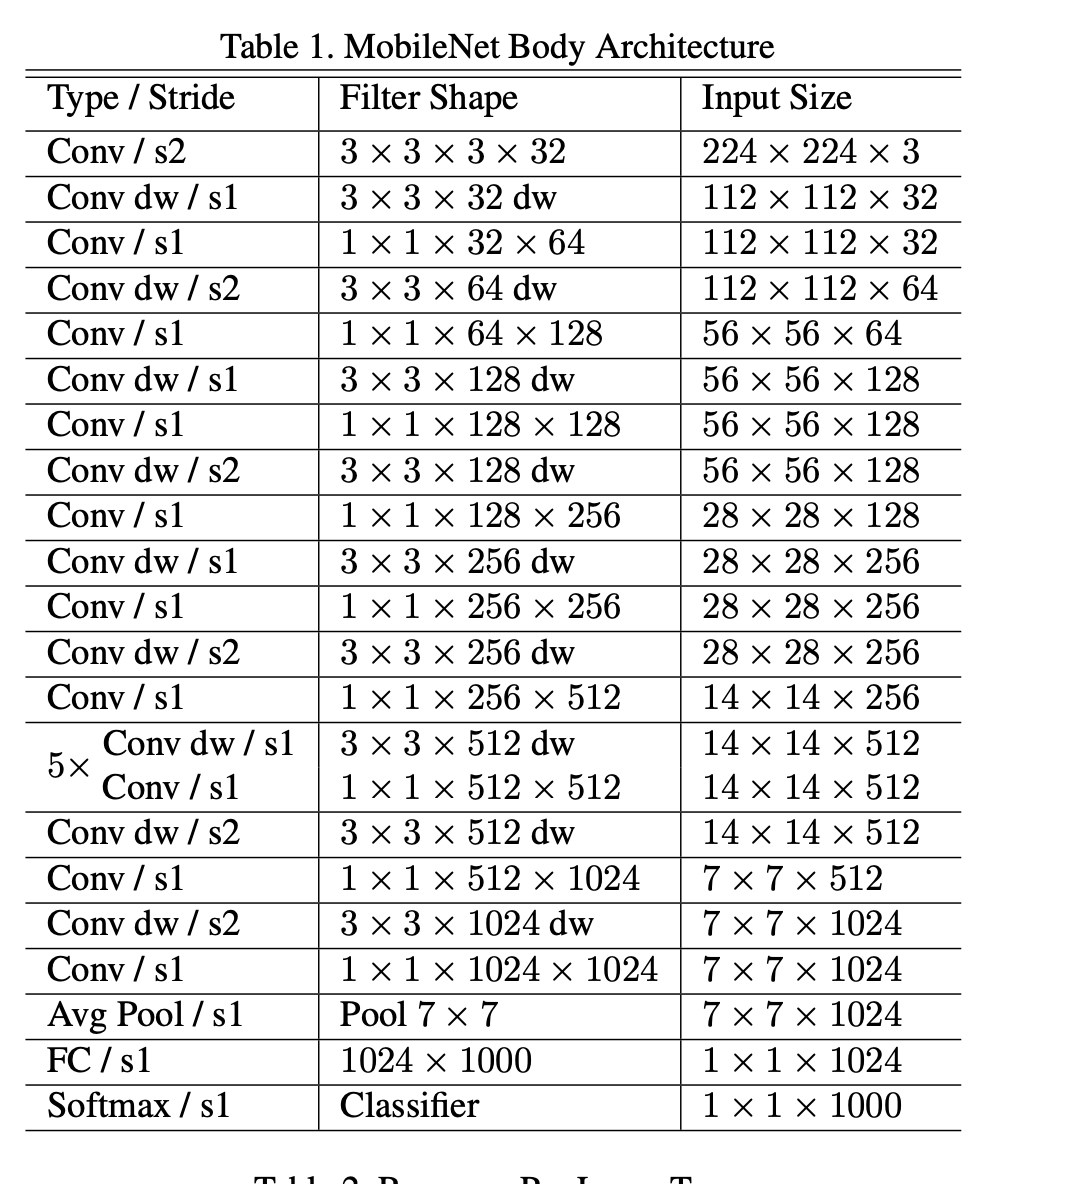

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split

class DataSet(Dataset):
    """Custom Dataset for loading images and their corresponding labels."""
    def __init__(self, features, transform=None):
        """Initialize the dataset with features and optional transformations.

        Args:
            features (list): List of dictionaries containing image paths and labels.
            transform (callable, optional): Optional transform to be applied on the images.
        """
        super(DataSet, self).__init__()
        self.features = features
        self.transform = transform

    def __len__(self):
        """Return the total number of samples in the dataset."""
        return len(self.features)

    def __getitem__(self, idx):
        """Retrieve an item from the dataset given an index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            dict: A dictionary containing the image tensor and its corresponding label.
        """
        # Get the path of the image based on the index
        paths = self.features[idx]["path"]

        # Read the image from the path
        images = torchvision.io.read_image(paths)

        # Ensure image has 3 channels
        if images.size(0) == 1:  # Check if the image is grayscale
            images = images.repeat(3, 1, 1)

        # Apply transformations if any
        if self.transform is not None:
            images = self.transform(images)

        # Retrieve the label for the current index
        label = torch.tensor(self.features[idx]["label"])
        return {"images": images, "labels": label}

# Define batch size and number of workers for DataLoader
batch_size = 32
num_workers = 2

# Define transformations for training images
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Define transformations for test/validation images
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Generate lists of paths with labels for both training and validation datasets
train_path = "/content/cifar10_raw/images/train/"
test_path = "/content/cifar10_raw/images/test/"

list_ = [name for name in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, name))]
string2int = {name: index for index, name in enumerate(list_)}

def get_path(path):
    """Generate a list of dictionaries with image paths, labels, and class names for a given dataset path."""
    paths = []
    for name in list_:
        l = glob(f"{path}{name}/*.png")
        for i in l:
            paths.append({
                "name": name,
                "path": i,
                "label": string2int[name]
            })
    return paths

train_paths = get_path(train_path)
test_paths = get_path(test_path)
test_paths, _ = train_test_split(test_paths, train_size=0.4, random_state=0)
train_paths, _ = train_test_split(train_paths, train_size=0.4, random_state=0)
train_paths, val_paths = train_test_split(train_paths, test_size=0.2, random_state=0)

# Initialize datasets with corresponding transformations
train_dataset = DataSet(train_paths, transform=train_transforms)
test_dataset = DataSet(test_paths, transform=test_transforms)
val_dataset = DataSet(val_paths, transform=test_transforms)

# Create DataLoaders for each dataset
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers)

# Define the MobileNet model
class MobileNet(L.LightningModule):
    def __init__(self, num_classes=10, learning_rate=1e-3):
        super(MobileNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),  # Conv / s2
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(32, 64, stride=1),  # Conv dw / s1
            DepthwiseSeparableConv(64, 128, stride=2),  # Conv dw / s2
            DepthwiseSeparableConv(128, 128, stride=1),  # Conv dw / s1
            DepthwiseSeparableConv(128, 256, stride=2),  # Conv dw / s2
            DepthwiseSeparableConv(256, 256, stride=1),  # Conv dw / s1
            DepthwiseSeparableConv(256, 512, stride=2),  # Conv dw / s2
            DepthwiseSeparableConv(512, 512, stride=1),  # Conv dw / s1
            DepthwiseSeparableConv(512, 512, stride=1),  # Conv dw / s1
            DepthwiseSeparableConv(512, 512, stride=1),  # Conv dw / s1
            DepthwiseSeparableConv(512, 512, stride=1),  # Conv dw / s1
            DepthwiseSeparableConv(512, 512, stride=1),  # Conv dw / s1
            DepthwiseSeparableConv(512, 1024, stride=2),  # Conv dw / s2
            DepthwiseSeparableConv(1024, 1024, stride=1),  # Conv dw / s1
        )

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1024, num_classes)
        self.softmax = nn.Softmax(dim=1)

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.learning_rate = learning_rate

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)  # Flatten for FC layer
        x = self.fc(x)
        x = self.softmax(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = nn.CrossEntropyLoss()(y_hat, y)
        val_acc = self.accuracy(y_hat, y)
        self.log('val_loss', val_loss)
        self.log('val_acc', val_acc)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        test_loss = nn.CrossEntropyLoss()(y_hat, y)
        test_acc = self.accuracy(y_hat, y)
        self.log('test_loss', test_loss)
        self.log('test_acc', test_acc)
        return test_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

# Define callbacks for checkpointing and early stopping
model_checkpoint = ModelCheckpoint(
    dirpath="checkpoint/",
    monitor="val_acc",
    verbose=True,
    mode="max",
    save_top_k=1
)
early_stopping = EarlyStopping(
    monitor="val_acc",
    mode="max",
    min_delta=1e-4,
    patience=5
)
callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

# Initialize MobileNet model
model = MobileNet(num_classes=10)

# Define the trainer and train the model
trainer = L.Trainer(max_epochs=2, detect_anomaly=True, callbacks=callbacks, accelerator="gpu", devices=1)
trainer.fit(model, train_dataloader, val_dataloader)


In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split

class DataSet(Dataset):
    """Custom Dataset for loading images and their corresponding labels."""
    def __init__(self, features, transform=None):
        """Initialize the dataset with features and optional transformations.

        Args:
            features (list): List of dictionaries containing image paths and labels.
            transform (callable, optional): Optional transform to be applied on the images.
        """
        super(DataSet, self).__init__()
        self.features = features
        self.transform = transform

    def __len__(self):
        """Return the total number of samples in the dataset."""
        return len(self.features)

    def __getitem__(self, idx):
        """Retrieve an item from the dataset given an index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            dict: A dictionary containing the image tensor and its corresponding label.
        """
        # Get the path of the image based on the index
        paths = self.features[idx]["path"]

        # Read the image from the path
        image = torchvision.io.read_image(paths).float() / 255.0

        # Convert grayscale image to 3 channels by stacking
        if image.size(0) == 1:  # Check if the image is grayscale
            image = image.repeat(3, 1, 1)

        # Convert tensor to PIL Image for transformations
        image = transforms.ToPILImage()(image)

        # Apply transformations if any
        if self.transform is not None:
            image = self.transform(image)

        # Retrieve the label for the current index
        label = torch.tensor(self.features[idx]["label"])
        return {"images": image, "labels": label}

# Define batch size and number of workers for DataLoader
batch_size = 32
num_workers = 2

# Define transformations for training images
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Define transformations for test/validation images
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Generate lists of paths with labels for both training and validation datasets
train_path = "/content/cifar10_raw/images/train/"
test_path = "/content/cifar10_raw/images/test/"

list_ = [name for name in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, name))]
string2int = {name: index for index, name in enumerate(list_)}

def get_path(path):
    """Generate a list of dictionaries with image paths, labels, and class names for a given dataset path."""
    paths = []
    for name in list_:
        l = glob(f"{path}{name}/*.png")
        for i in l:
            paths.append({
                "name": name,
                "path": i,
                "label": string2int[name]
            })
    return paths

train_paths = get_path(train_path)
test_paths = get_path(test_path)
test_paths, _ = train_test_split(test_paths, train_size=0.4, random_state=0)
train_paths, _ = train_test_split(train_paths, train_size=0.4, random_state=0)
train_paths, val_paths = train_test_split(train_paths, test_size=0.2, random_state=0)

# Initialize datasets with corresponding transformations
train_dataset = DataSet(train_paths, transform=train_transforms)
test_dataset = DataSet(test_paths, transform=test_transforms)
val_dataset = DataSet(val_paths, transform=test_transforms)

# Create DataLoaders for each dataset
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers)

# Define the MobileNet model
class MobileNet(L.LightningModule):
    def __init__(self, num_classes=10, learning_rate=1e-3):
        super(MobileNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),  # Conv / s2
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(32, 64, stride=1),  # Conv dw / s1
            DepthwiseSeparableConv(64, 128, stride=2),  # Conv dw / s2
            DepthwiseSeparableConv(128, 128, stride=1),  # Conv dw / s1
            DepthwiseSeparableConv(128, 256, stride=2),  # Conv dw / s2
            DepthwiseSeparableConv(256, 256, stride=1),  # Conv dw / s1
            DepthwiseSeparableConv(256, 512, stride=2),  # Conv dw / s2
            DepthwiseSeparableConv(512, 512, stride=1),  # Conv dw / s1
            DepthwiseSeparableConv(512, 512, stride=1),  # Conv dw / s1
            DepthwiseSeparableConv(512, 512, stride=1),  # Conv dw / s1
            DepthwiseSeparableConv(512, 512, stride=1),  # Conv dw / s1
            DepthwiseSeparableConv(512, 512, stride=1),  # Conv dw / s1
            DepthwiseSeparableConv(512, 1024, stride=2),  # Conv dw / s2
            DepthwiseSeparableConv(1024, 1024, stride=1),  # Conv dw / s1
        )

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1024, num_classes)
        self.softmax = nn.Softmax(dim=1)

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.learning_rate = learning_rate

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)  # Flatten for FC layer
        x = self.fc(x)
        x = self.softmax(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = nn.CrossEntropyLoss()(y_hat, y)
        val_acc = self.accuracy(y_hat, y)
        self.log('val_loss', val_loss)
        self.log('val_acc', val_acc)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        test_loss = nn.CrossEntropyLoss()(y_hat, y)
        test_acc = self.accuracy(y_hat, y)
        self.log('test_loss', test_loss)
        self.log('test_acc', test_acc)
        return test_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

# Define callbacks for checkpointing and early stopping
model_checkpoint = ModelCheckpoint(
    dirpath="checkpoint/",
    monitor="val_acc",
    verbose=True,
    mode="max",
    save_top_k=1
)
early_stopping = EarlyStopping(
    monitor="val_acc",
    mode="max",
    min_delta=1e-4,
    patience=5
)
callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

# Initialize MobileNet model
model = MobileNet(num_classes=10)

# Define the trainer and train the model
trainer = L.Trainer(max_epochs=2, detect_anomaly=True, callbacks=callbacks, accelerator="gpu", devices=1)
trainer.fit(model,[_{{{CITATION{{{_1{](https://github.com/Asad-Ismail/soccer_analytics/tree/7d256b98eb92e918c5ab4e35b4393933d66d9dfa/utils%2Fgeneral.py)